In [104]:
# from google.colab import drive
# drive.mount("/content/gdrive")

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,8]

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [106]:
# dat = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/CSE 5819/Data/aqi_sample_data_wakulla_florida_bdate_20170101_edate_20191231_wind_speed_dir.csv")
dat = pd.read_csv("Data/aqi_sample_data_wakulla_florida_bdate_20150101_edate_20191231_wind_speed_dir.csv")
print(dat.shape)
dat.head(5)

(26280, 12)


,latitude,longitude,date_gmt,time_gmt,datetime_gmt,state,county,Wind_Speed,Wind_Direction,Barometric_Pressure,cos_Wind_Dir,sin_Wind_Dir
0,30.0925,-84.161111,1/1/2017,5:00,1/1/2017 5:00,Florida,Wakulla,6.7,83.0,1017.0,0.121869,0.992546
1,30.0925,-84.161111,1/1/2017,6:00,1/1/2017 6:00,Florida,Wakulla,5.2,88.0,1017.0,0.034899,0.999391
2,30.0925,-84.161111,1/1/2017,7:00,1/1/2017 7:00,Florida,Wakulla,5.0,94.0,1017.0,-0.069756,0.997564
3,30.0925,-84.161111,1/1/2017,8:00,1/1/2017 8:00,Florida,Wakulla,5.6,104.0,1016.0,-0.241922,0.970296
4,30.0925,-84.161111,1/1/2017,9:00,1/1/2017 9:00,Florida,Wakulla,7.0,129.0,1016.0,-0.629320,0.777146


Working off of the notebook here: https://towardsdatascience.com/predictive-analytics-time-series-forecasting-with-gru-and-bilstm-in-tensorflow-87588c852915

## Pre-processing

- Need to fill in missing values (fill-forward)
- Need to create lagged variables as inputs and restructure the data (split into predictors and responses)
- Train and test split
- Re-scale the data 


<AxesSubplot:>

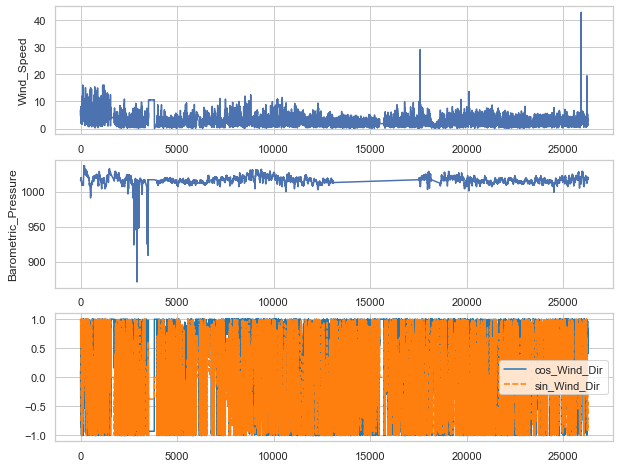

In [107]:
sns.set_theme(style = "whitegrid")

fig, axs = plt.subplots(nrows = 3)
sns.lineplot(data = dat["Wind_Speed"], palette = "tab10", ax = axs[0])
sns.lineplot(data = dat[ "Barometric_Pressure"], palette = "tab10", ax = axs[1])
sns.lineplot(data = dat[["cos_Wind_Dir", "sin_Wind_Dir"]], palette = "tab10", ax = axs[2])

Fill the missing data with fill-forward.

In [108]:
from pandas._config import dates

dat_prep = dat.copy()
dat_prep["datetime_gmt"] = pd.to_datetime(dat_prep["datetime_gmt"])
# dat_prep.rename(columns = {"datetime_gmt": "datetime"}, inplace = True)
# dat = dat.loc[~dat.Barometric_Pressure.isna(),:]
dat_prep = dat_prep.set_index("datetime_gmt")
dat_prep = dat.drop(['latitude', 'longitude', 'date_gmt', 'time_gmt', 'state', 'county', 'Wind_Direction'], axis = 1)

dat_prep.fillna(method = "pad", inplace = True)
dat_prep = dat_prep.dropna()
print(dat_prep.shape)
dat_prep.head(5)

(26280, 5)


,datetime_gmt,Wind_Speed,Barometric_Pressure,cos_Wind_Dir,sin_Wind_Dir
0,1/1/2017 5:00,6.7,1017.0,0.121869,0.992546
1,1/1/2017 6:00,5.2,1017.0,0.034899,0.999391
2,1/1/2017 7:00,5.0,1017.0,-0.069756,0.997564
3,1/1/2017 8:00,5.6,1016.0,-0.241922,0.970296
4,1/1/2017 9:00,7.0,1016.0,-0.629320,0.777146


In [109]:
dat_prep = dat_prep.set_index("datetime_gmt")
dat_prep

,Wind_Speed,Barometric_Pressure,cos_Wind_Dir,sin_Wind_Dir
datetime_gmt,,,,
1/1/2017 5:00,6.7,1017.0,0.121869,0.992546
1/1/2017 6:00,5.2,1017.0,0.034899,0.999391
1/1/2017 7:00,5.0,1017.0,-0.069756,0.997564
1/1/2017 8:00,5.6,1016.0,-0.241922,0.970296
1/1/2017 9:00,7.0,1016.0,-0.629320,0.777146
...,...,...,...,...
1/1/2020 0:00,1.6,1019.0,0.453991,-0.891007
1/1/2020 1:00,1.6,1019.0,0.500000,-0.866025
1/1/2020 2:00,2.1,1019.0,0.601815,-0.798636


Train and Test split. I'll use 70% and 30%.

In [110]:
n_train = int(len(dat_prep) * 0.7)

train_dat = dat_prep.iloc[:n_train]
test_dat = dat_prep.iloc[n_train:]

Transformation pre-processing. I'll use the MinMaxScaler() for now. I'll try detrending later.

In [111]:
scaler_speed = MinMaxScaler().fit(train_dat[['Wind_Speed']])
scaler_press = MinMaxScaler().fit(train_dat[['Barometric_Pressure']])

train_dat[['Wind_Speed']] = scaler_speed.transform(train_dat[['Wind_Speed']])
test_dat[['Wind_Speed']] = scaler_speed.transform(test_dat[['Wind_Speed']])

train_dat[['Barometric_Pressure']] = scaler_press.transform(train_dat[['Barometric_Pressure']])
test_dat[['Barometric_Pressure']] = scaler_press.transform(test_dat[['Barometric_Pressure']])

train_dat.head(5)

,Wind_Speed,Barometric_Pressure,cos_Wind_Dir,sin_Wind_Dir
datetime_gmt,,,,
1/1/2017 5:00,0.229452,0.879518,0.121869,0.992546
1/1/2017 6:00,0.178082,0.879518,0.034899,0.999391
1/1/2017 7:00,0.171233,0.879518,-0.069756,0.997564
1/1/2017 8:00,0.191781,0.873494,-0.241922,0.970296
1/1/2017 9:00,0.239726,0.873494,-0.629320,0.777146


Input data.

The inputs are the previous time points of the output variable and the previous time points of the other variables.

In [140]:
def create_dataset(dat, lags = 1):
  """ GRU takes a 3D array so the data must be re-shaped to:
  - [N, T, P]
  - N = number of samples
  - T = number of time steps
  - P = number of predictors
  """
  Inputs, Outputs = [], []
  X = dat.to_numpy()

  for i in range(len(X) - lags):
    v = X[i:i+lags]
    Inputs.append(v)
    Outputs.append(X[i + lags])

  return np.array(Inputs), np.array(Outputs)

lags = 96

X_train, y_train = create_dataset(train_dat, lags)
X_test, y_test = create_dataset(test_dat, lags)

y_train = y_train[:, 1:2]
y_test = y_test[:, 1:2]

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (18300, 96, 4)
y_train.shape:  (18300, 1)
X_test.shape:  (7788, 96, 4)
y_test.shape:  (7788, 1)


In [141]:
y_train

array([[0.84939759],
       [0.84939759],
       [0.84939759],
       ...,
       [0.87951807],
       [0.87951807],
       [0.87951807]])

## Squared Error Loss Model

### Build the Model

Building the GRU model with the specified number of hidden units and squared error loss. 

In [148]:
# normal GRU model with mse loss function
def create_GRU(units):
  model = Sequential()

  # Input Layer
  model.add(GRU(units = units, return_sequences=True, 
            input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))

  # Hidden Layer
  model.add(GRU(units = 16))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))

  # Compile Model
  model.compile(optimizer = 'adam', loss = 'mse') # loss function will be changed 

  return model
# normal GRU model with mse loss function
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 15)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 32, shuffle = False, 
                        callbacks = [early_stop])
    return history

def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

In [118]:
# make and plot test forecasts with the Gaussian GRU model.
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

def plot_future(prediction, model_name, y_test, ylab):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')    
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel(ylab)

def make_predictions(X_test, y_test, model, scaler, model_name, ylab):
    prediction = model.predict(X_test)
    pred = np.append(prediction, prediction, 1)
    pred = scaler.inverse_transform(pred)
    pred_gru = pred[:,0]

    plot_future(pred_gru, model_name, y_test, ylab)

    return prediction, pred_gru

Fitting the model with 100 epochs and batch size = 16 with early stopping for no improvements of validation loss in 10 epochs.

Epoch 1/100
458/458 [==============================] - 16s 30ms/step - loss: 0.0292 - val_loss: 0.0017
Epoch 2/100
458/458 [==============================] - 14s 30ms/step - loss: 0.0111 - val_loss: 2.6114e-04
Epoch 3/100
458/458 [==============================] - 13s 29ms/step - loss: 0.0090 - val_loss: 9.2370e-04
Epoch 4/100
458/458 [==============================] - 13s 29ms/step - loss: 0.0067 - val_loss: 1.9723e-04
Epoch 5/100
458/458 [==============================] - 13s 29ms/step - loss: 0.0050 - val_loss: 2.4731e-04
Epoch 6/100
458/458 [==============================] - 13s 29ms/step - loss: 0.0037 - val_loss: 2.2166e-04
Epoch 7/100
458/458 [==============================] - 13s 28ms/step - loss: 0.0028 - val_loss: 2.9738e-04
Epoch 8/100
458/458 [==============================] - 13s 28ms/step - loss: 0.0022 - val_loss: 3.3715e-04
Epoch 9/100
458/458 [==============================] - 13s 28ms/step - loss: 0.0018 - val_loss: 3.2674e-04
Epoch 10/100
458/458 [===================

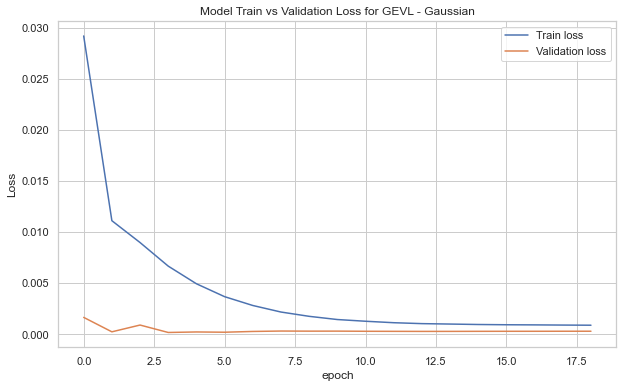

In [119]:
model_GRU = create_GRU(32)
history_gru = fit_model(model_GRU)

plot_loss (history_gru, 'GEVL - Gaussian')

## GEVL Functions

$$L_{GEVL}(X^1, Y) = -\frac{1}{T \tau} \sum_{t = 1}^T \log \mathcal{K}\left(\frac{f_\theta (X^1_{1:t}) - \phi(y_t)}{\tau}\right)$$
where $Y = {y_1,..., y_{T-1}}$ with $y_t = x_{t+1}$, $\mathcal{K}$ is a kernel density estimate with bandwidth $\tau$, $f_\theta$ is our model output indexed by $\theta$, and $\phi(t_t)$ is a transformation function.

- Gaussian: $\mathcal{K}(x) = \tau^{-1}\exp\left[-\frac{(x - \mu)^2}{\tau}\right]$
- Gumbel: $\mathcal{K}(x) = \exp\left[-(z + e^{-z})\right]$ where $z = \frac{x - \mu}{\beta}$
- Fr\'{e}chet: $\mathcal{K}(x) = \frac{\alpha}{s}\left(z\right)^{-1-\alpha}\exp\left[-z^{-\alpha}\right]$ where $z = \frac{x + s(\alpha/(1 + \alpha))^{1/\alpha}}{s}$ for $x > 0$
- Gamma: $\mathcal{K}(x) = x^{\alpha-1} e^{-x/\beta}$, where $x > 0$
- Cauchy: $\mathcal{K}(x) = (1 + \frac{x - m}{\gamma})^{-2}$, where $x \in \mathbb{R}$
- Pareto: $\mathcal{K}(x) = \frac{s^\alpha}{x^{\alpha+1}}$, where $x > s$

Here's the corresponding GEVL functions:

- Gaussian: $L_{Gaussian}(X^k, Y) = \frac{1}{T} \sum_{t=1}^T \delta^2 = L_{SquaredError}(X^k, Y)$
- Gumbel: $L_{Gumbel}(X^k, Y) = \frac{1}{T} \sum_{t=1}^T \delta^2 \left[1 - \exp\left(-\delta^2\right)\right]^\gamma$
- Fr\'echet: $L_{Fr\acute{e}chet}(X^k, Y) = \frac{\alpha+1}{T} \sum_{t=1}^T \log z + \frac{1}{T} \sum_{t=1}^T z^{-\alpha}$
- Cauchy: $L_{Cauchy}(X^k, Y) = \frac{2}{T} \sum_{t=1}^T \log \left[1 + \delta \right]$
- Pareto: $L_{Pareto}(X^k, Y) = \frac{\alpha + 1}{T} \sum_{t=1}^T \log\delta$

I'm going to implement the Gumbel one here. Others will be in a separate notebook.

In [146]:
# Gaussian
def Gaussian_GEVL_fn():
  def gevl_Gaussian(y_true, y_pred):
    delta = y_pred - y_true
    gevl = tf.exp(tf.square(-delta,2))
    return tf.reduce_mean(gevl, axis = -1)
  return gevl_Gaussian

# Gumbel GEVL
def gumbel_GEVL_fn(gamma):
  def gevl_gumbel(y_true, y_pred):
    delta = y_pred - y_true
    gevl = tf.multiply(tf.pow(1 - tf.exp(-tf.square(delta)), gamma), tf.square(delta))
    return tf.reduce_mean(gevl, axis = -1)
  return gevl_gumbel

# Frechet GEVL
def Frechet_GEVL_fn(alpha,s):
  def gevl_Frechet(y_true, y_pred):
    delta = y_pred - y_true
    Zeta = tf.divide(delta,s) + tf.pow( tf.divide(alpha,(1.0 + alpha)),
                             tf.divide(1.0, alpha))
    gevl1 = tf.multiply(alpha + 1.0, tf.math.log(Zeta))
    gevl2 = tf.pow(Zeta, -alpha)
    gevl = tf.add(gevl1, gevl2)
    return tf.reduce_mean(gevl, axis = -1)
  return gevl_Frechet

# Cauchy
def Cauchy_GEVL_fn(tau):
  def gevl_Cauchy(y_true, y_pred):
    delta = y_pred - y_true
    gevl = tf.math.log(1.0 + tf.pow(delta / tau, 2.0))
    return tf.reduce_mean(gevl, axis = -1)
  return gevl_Cauchy

# Pareto
def Pareto_GEVL_fn(alpha,s):
  def gevl_Pareto(y_true, y_pred):
    delta = y_pred - y_true
    gevl = tf.multiply((tf.pow(s,alpha)), tf.pow(delta,-(alpha + 1)))
    return tf.reduce_mean(gevl, axis = -1)
  return gevl_Pareto

Epoch 1/100
458/458 [==============================] - 17s 33ms/step - loss: 0.0140 - val_loss: 1.0943e-06
Epoch 2/100
458/458 [==============================] - 16s 34ms/step - loss: 9.8948e-04 - val_loss: 6.4227e-07
Epoch 3/100
458/458 [==============================] - 15s 34ms/step - loss: 6.5615e-04 - val_loss: 3.4498e-07
Epoch 4/100
458/458 [==============================] - 13s 28ms/step - loss: 5.0966e-04 - val_loss: 3.5779e-07
Epoch 5/100
458/458 [==============================] - 13s 28ms/step - loss: 4.4695e-04 - val_loss: 1.5508e-07
Epoch 6/100
458/458 [==============================] - 13s 28ms/step - loss: 3.6419e-04 - val_loss: 9.9304e-08
Epoch 7/100
458/458 [==============================] - 13s 28ms/step - loss: 3.5576e-04 - val_loss: 1.1216e-07
Epoch 8/100
458/458 [==============================] - 13s 28ms/step - loss: 3.1022e-04 - val_loss: 1.3820e-07
Epoch 9/100
458/458 [==============================] - 13s 28ms/step - loss: 2.7132e-04 - val_loss: 1.1288e-07
Epoch

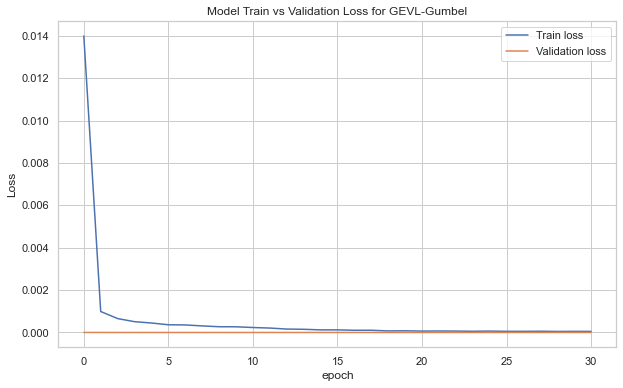

In [121]:
def create_GRU_Gumbel_GEVL(units):
  model = Sequential()

  # Input Layer
  model.add(GRU(units = units, return_sequences=True,
            input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))

  # Hidden Layer
  model.add(GRU(units = 16))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))

  # Compile Model
  model.compile(optimizer = 'adam', loss = gumbel_GEVL_fn(gamma = 1.1))

  return model

model_GRU_gumbel = create_GRU_Gumbel_GEVL(32)
history_gumbel = fit_model(model_GRU_gumbel)

plot_loss(history_gumbel, 'GEVL-Gumbel')

In [149]:
def create_GRU_Cauchy_GEVL(units):
  model = Sequential()

  # Input Layer
  model.add(GRU(units = units, return_sequences=True,
            input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))

  # Hidden Layer
  model.add(GRU(units = 16))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))

  # Compile Model
  model.compile(optimizer = 'adam', loss = Cauchy_GEVL_fn(tau = 10.0))

  return model

model_GRU_cauchy = create_GRU_Cauchy_GEVL(32)
history_cauchy = fit_model(model_GRU_cauchy)

plot_loss(history_cauchy, 'GEVL-Cauchy')

Epoch 1/100
458/458 [==============================] - 17s 30ms/step - loss: 3.0990e-04 - val_loss: 4.4432e-06
Epoch 2/100
458/458 [==============================] - 14s 30ms/step - loss: 1.1753e-04 - val_loss: 2.1573e-06
Epoch 3/100
458/458 [==============================] - 14s 30ms/step - loss: 8.8772e-05 - val_loss: 2.1623e-06
Epoch 4/100
458/458 [==============================] - 13s 29ms/step - loss: 6.8871e-05 - val_loss: 1.9496e-06
Epoch 5/100
458/458 [==============================] - 13s 29ms/step - loss: 5.1806e-05 - val_loss: 8.7013e-06
Epoch 6/100
111/458 [======>.......................] - ETA: 9s - loss: 6.4276e-05

KeyboardInterrupt: 

### Model Performance

- Plots of training and validation loss
- Predictions vs test data
- RMSE

244/244 [==============================] - 2s 7ms/step


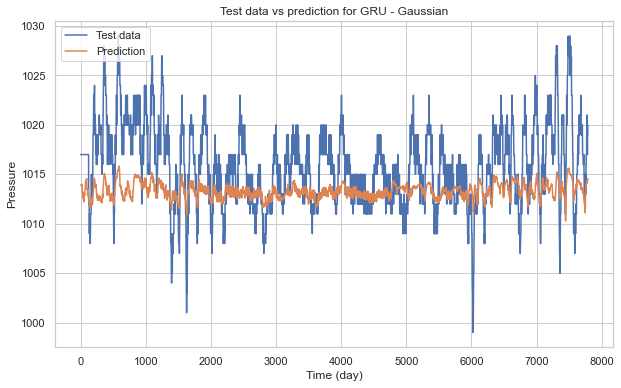

In [181]:
y_test_speed = scaler_speed.inverse_transform(y_test)
y_test_press = scaler_press.inverse_transform(y_test)
prediction_gru, pred_gru = make_predictions(X_test, y_test_press, model_GRU, scaler_press,
                                            "GRU - Gaussian", "Pressure")

244/244 [==============================] - 2s 7ms/step


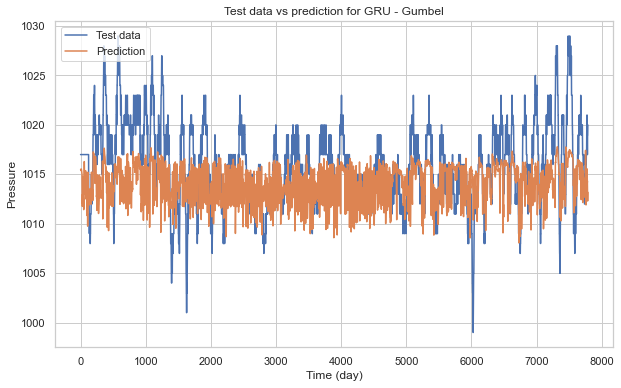

In [182]:
prediction_gumbel, pred_gumbel = make_predictions(X_test, y_test_press, model_GRU_gumbel, scaler_press, 
                                                    "GRU - Gumbel", "Pressure")

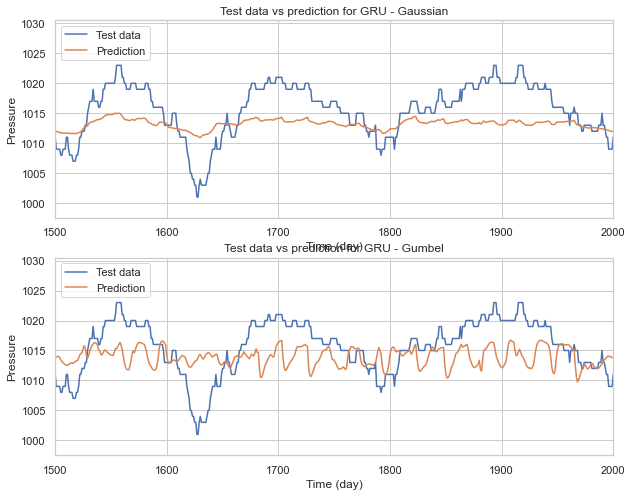

In [183]:
def plot_future2(ax, prediction, model_name, y_test, ylab):
    range_future = len(prediction)
    ax.plot(np.arange(range_future), np.array(y_test), 
             label='Test data')
    ax.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')    
    ax.set_title('Test data vs prediction for ' + model_name)
    ax.legend(loc='upper left')
    ax.set_xlabel('Time (day)')
    ax.set_ylabel(ylab)
    ax.set_xlim(1500, 2000)

fig, axs = plt.subplots(2)
plot_future2(axs[0], pred_gru, "GRU - Gaussian", y_test_press, "Pressure")
plot_future2(axs[1], pred_gumbel, "GRU - Gumbel", y_test_press, "Pressure")


In [184]:
# compare the test forecasts using RMSE and MAE.

evaluate_prediction(pred_gru, y_test_press, 'GRU - Gaussian')
print("################")
evaluate_prediction(pred_gumbel, y_test_press, 'GRU - Gumbel')

GRU - Gaussian:
Mean Absolute Error: 3.7766
Root Mean Square Error: 4.8076

################
GRU - Gumbel:
Mean Absolute Error: 3.7026
Root Mean Square Error: 4.7333



Text(0, 0.5, 'GRU - Gumbel')

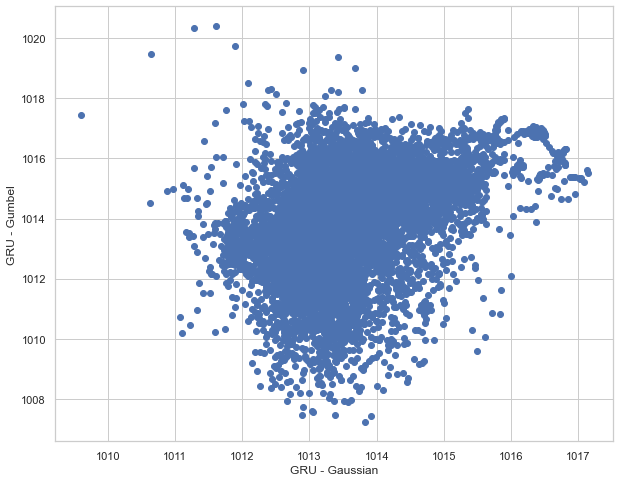

In [90]:
fig, ax = plt.subplots()
ax.scatter(x = pred_gru, y = pred_gumbel)
ax.set_xlabel("GRU - Gaussian")
ax.set_ylabel("GRU - Gumbel")

Text(0, 0.5, 'Residual - Gumbel')

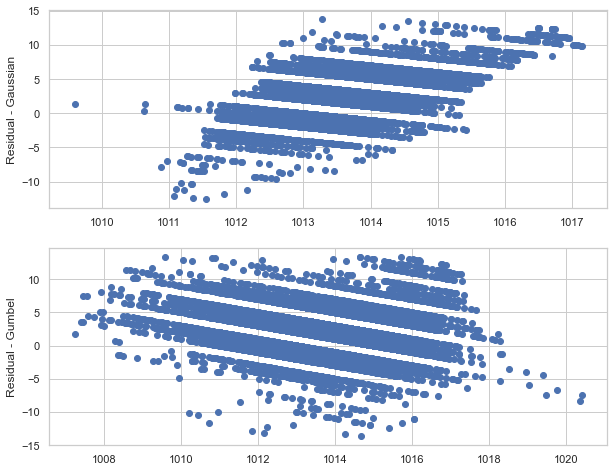

In [93]:
fig, axs = plt.subplots(2)
axs[0].scatter(y = np.subtract(y_test_press[:,0], pred_gru), x = pred_gru)
axs[1].scatter(y = np.subtract(y_test_press[:,0], pred_gumbel), x = pred_gumbel)
axs[0].set_ylabel("Residual - Gaussian")
axs[1].set_ylabel("Residual - Gumbel")